In [3]:
import numpy as np
import pandas as pd
import csv
from numpy import array, asarray, mod, sin, cos, tan, sqrt, arctan2, \
    floor, rad2deg, deg2rad, stack
from scipy.linalg import inv
from scipy import *
import warnings
warnings.filterwarnings("ignore")
__all__ = ['get_easting_northing_from_gps_lat_long',
           'get_gps_lat_long_from_easting_northing']

In [4]:
class Ellipsoid(object):
    """Class to hold Ellipsoid information."""
    def __init__(self, a, b, F_0):
        self.a = a
        self.b = b
        self.n = (a-b)/(a+b)
        self.e2 = (a**2-b**2)/a**2
        self.F_0 = F_0
        self.H = 0


class Datum(Ellipsoid):
    """Class to hold datum information."""

    def __init__(self, a, b, F_0, phi_0, lam_0, E_0, N_0, H):
        super().__init__(a, b, F_0)
        self.phi_0 = phi_0
        self.lam_0 = lam_0
        self.E_0 = E_0
        self.N_0 = N_0
        self.H = H


def rad(deg, min=0, sec=0):
    """Convert degrees/minutes/seconds into radians.

    Parameters
    ----------

    deg: float/arraylike
       Value(s) in degrees
    min: float/arraylike
       Value(s) in minutes
    sec: float/arraylike
       Value(s) in (angular) seconds

    Returns
    -------
    numpy.ndarray
         Equivalent values in radians
    """
    deg = asarray(deg)
    min = asarray(min)
    sec = asarray(sec)
    return deg2rad(deg+min/60.+sec/3600.)


def deg(rad, dms=False):
    """Convert degrees into radians.

    Parameters
    ----------

    deg: float/arraylike
        Value(s) in degrees

    Returns
    -------
    np.ndarray
        Equivalent values in radians.
    """
    rad = asarray(rad)
    deg = rad2deg(rad)
    if dms:
        min = 60.0*mod(deg, 1.0)
        sec = 60.0*mod(min, 1.0)
        return stack((floor(deg),  floor(min), sec.round(4)))
    else:
        return deg


# data for OSGB36 lat/long datum.
osgb36 = Datum(a=6377563.396,
               b=6356256.910,
               F_0=0.9996012717,
               phi_0=rad(49.0),
               lam_0=rad(-2.),
               E_0=400000,
               N_0=-100000,
               H=24.7)

# data for WGS84 GPS datum.
wgs84 = Ellipsoid(a=6378137,
                  b=6356752.3142,
                  F_0=0.9996)


def lat_long_to_xyz(phi, lam, rads=False, datum=osgb36):
    """Convert latitude/longitude in a given datum into
    Cartesian (x, y, z) coordinates.
    """
    if not rads:
        phi = rad(phi)
        lam = rad(lam)

    nu = datum.a*datum.F_0/sqrt(1-datum.e2*sin(phi)**2)

    return array(((nu+datum.H)*cos(phi)*cos(lam),
                  (nu+datum.H)*cos(phi)*sin(lam),
                  ((1-datum.e2)*nu+datum.H)*sin(phi)))

def xyz_to_lat_long(x, y, z, rads=False, datum=osgb36):
    """Convert Cartesian (x,y,z) coordinates into
    latitude and longitude in a given datum.
    """

    p = sqrt(x**2+y**2)

    lam = arctan2(y, x)
    phi = arctan2(z, p*(1-datum.e2))

    for _ in range(10):

        nu = datum.a*datum.F_0/sqrt(1-datum.e2*sin(phi)**2)
        dnu = (-datum.a*datum.F_0*cos(phi)*sin(phi)
               / (1-datum.e2*sin(phi)**2)**1.5)

        f0 = (z + datum.e2*nu*sin(phi))/p - tan(phi)
        f1 = datum.e2*(nu**cos(phi)+dnu*sin(phi))/p - 1.0/cos(phi)**2
        phi -= f0/f1

    if not rads:
        phi = deg(phi)
        lam = deg(lam)

    return phi, lam

In [5]:
def get_easting_northing_from_gps_lat_long(phi, lam, rads=False):
    """ Get OSGB36 easting/northing from GPS latitude and
    longitude pairs.

    Parameters
    ----------

    phi: float/arraylike
        GPS (i.e. WGS84 datum) latitude value(s)
    lam: float/arraylike
        GPS (i.e. WGS84 datum) longitude value(s).
    rads: bool (optional)
        If true, specifies input is is radians.

    Returns
    -------
    numpy.ndarray
        Easting values (in m)
    numpy.ndarray
        Northing values (in m)

    Examples
    --------

    >>> get_easting_northing_from_gps_lat_long([55.5], [-1.54])
    (array([429157.0]), array([623009]))

    References
    ----------

    Based on the formulas in "A guide to coordinate systems in Great Britain".

    See also https://webapps.bgs.ac.uk/data/webservices/convertForm.cfm
    """
    phi = phi[0]
    lam = lam[0]
    if not rads:
        lat_1 = phi * pi/180
        lon_1 = lam * pi/180
    else:
        lat_1 = phi
        lon_1 = lam

    #Want to convert to the Airy 1830 ellipsoid, which has the following:
    a_1, b_1 =6378137.000, 6356752.3141 #The GSR80 semi-major and semi-minor axes used for WGS84(m)
    e2_1 = 1- (b_1*b_1)/(a_1*a_1) #The eccentricity of the GRS80 ellipsoid
    nu_1 = a_1/sqrt(1-e2_1*sin(lat_1)**2)

    #First convert to cartesian from spherical polar coordinates
    H = 0 #Third spherical coord.
    x_1 = (nu_1 + H)*cos(lat_1)*cos(lon_1)
    y_1 = (nu_1+ H)*cos(lat_1)*sin(lon_1)
    z_1 = ((1-e2_1)*nu_1 +H)*sin(lat_1)
    #Perform Helmut transform (to go between GRS80 (_1) and Airy 1830 (_2))
    s = 20.4894*10**-6 #The scale factor -1
    tx, ty, tz = -446.448, 125.157, -542.060 #The translations along x,y,z axes respectively
    rxs,rys,rzs = -0.1502, -0.2470, -0.8421#The rotations along x,y,z respectively, in seconds
    rx, ry, rz = rxs*pi/(180*3600.), rys*pi/(180*3600.), rzs*pi/(180*3600.) #In radians
    x_2 = tx + (1+s)*x_1 + (-rz)*y_1 + (ry)*z_1
    y_2 = ty + (rz)*x_1+ (1+s)*y_1 + (-rx)*z_1
    z_2 = tz + (-ry)*x_1 + (rx)*y_1 +(1+s)*z_1
    
    a=6377563.396
    b=6356256.910
    e2 = 1- (b*b)/(a*a) #The eccentricity of the Airy 1830 ellipsoid
    p = sqrt(x_2**2 + y_2**2)

    #Lat is obtained by an iterative proceedure:
    lat = arctan2(z_2,(p*(1-e2))) #Initial value
    latold = 2*pi
    while abs(lat - latold)>10**-16:
        lat, latold = latold, lat
        nu = a/sqrt(1-e2*sin(latold)**2)
        lat = arctan2(z_2+e2*nu*sin(latold), p)

    #Lon and height are then pretty easy
    lon = arctan2(y_2,x_2)
    H = p/cos(lat) - nu
    n = (a-b)/(a+b)

    #meridional radius of curvature
    F_0=0.9996012717
    rho = a*F_0*(1-e2)*(1-e2*sin(lat)**2)**(-1.5)
    eta2 = nu*F_0/rho-1

    phi_0=rad(49.0)
    lam_0=rad(-2.)
    M1 = (1 + n + (5/4)*n**2 + (5/4)*n**3) * (lat-phi_0)
    M2 = (3*n + 3*n**2 + (21/8)*n**3) * sin(lat-phi_0) * cos(lat+phi_0)
    M3 = ((15/8)*n**2 + (15/8)*n**3) * sin(2*(lat-phi_0)) * cos(2*(lat+phi_0))
    M4 = (35/24)*n**3 * sin(3*(lat-phi_0)) * cos(3*(lat+phi_0))
    
    #meridional arc
    M = b * F_0 * (M1 - M2 + M3 - M4)
    N_0=-100000
    E_0=400000
    I = M + N_0
    II = nu*F_0*sin(lat)*cos(lat)/2
    III = nu*F_0*sin(lat)*cos(lat)**3*(5- tan(lat)**2 + 9*eta2)/24
    IIIA = nu*F_0*sin(lat)*cos(lat)**5*(61- 58*tan(lat)**2 + tan(lat)**4)/720
    IV = nu*F_0*cos(lat)
    V = nu*F_0*cos(lat)**3*(nu/rho - tan(lat)**2)/6
    VI = nu*F_0*cos(lat)**5*(5 - 18* tan(lat)**2 + tan(lat)**4 + 14*eta2 - 58*eta2*tan(lat)**2)/120

    N = I + II*(lon-lam_0)**2 + III*(lon - lam_0)**4 + IIIA*(lon -lam_0)**6
    E = E_0 + IV*(lon-lam_0) + V*(lon- lam_0)**3 + VI*(lon - lam_0)**5 
    
    return (array([E]),array([N]))


In [6]:
get_easting_northing_from_gps_lat_long([55.5], [-1.54])

(array([429157.5000801]), array([623009.04594631]))

In [7]:
get_easting_northing_from_gps_lat_long([53.480556], [-1.441674])

(array([437150.46695872]), array([398348.66912768]))

### test_get_easting_northing_from_gps_lat_long

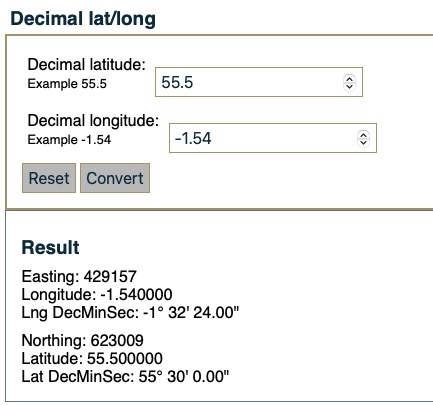

In [8]:
from pytest import mark

In [9]:
def test_get_easting_northing_from_gps_lat_long():
    """Check get_easting_northing_from_gps_lat_long"""

    data1,data2 = get_easting_northing_from_gps_lat_long([55.5], [-1.54])

    if data1 is NotImplemented:
        assert False
    #It passes when they are close
    assert np.isclose(data1[0], 429157.0).all()
    assert np.isclose(data2[0], 623009.0).all()
    
    
if __name__ == "__main__":
    test_get_easting_northing_from_gps_lat_long()

In [11]:
def test_get_easting_northing_from_gps_lat_long():
    """Check get_easting_northing_from_gps_lat_long"""

    data1,data2 = get_easting_northing_from_gps_lat_long([55.5], [-1.54])

    if data1 is NotImplemented:
        assert False
    #An Error occurs when not close
    assert np.isclose(data1[0], 429157.0).all()
    assert np.isclose(data2[0], 623000.0).all()
    
    
if __name__ == "__main__":
    test_get_easting_northing_from_gps_lat_long()

AssertionError: 

In [12]:
def get_gps_lat_long_from_easting_northing(east, north,
                                           rads=False, dms=False):
    """ Get OSGB36 easting/northing from GPS latitude and
    longitude pairs.

    Parameters
    ----------

    east: float/arraylike
        OSGB36 easting value(s) (in m).
    north: float/arraylike
        OSGB36 easting value(s) (in m).
    rads: bool (optional)
        If true, specifies ouput is is radians.
    dms: bool (optional)
        If true, output is in degrees/minutes/seconds. Incompatible
        with rads option.

    Returns
    -------
    numpy.ndarray
        GPS (i.e. WGS84 datum) latitude value(s).
    numpy.ndarray
        GPS (i.e. WGS84 datum) longitude value(s).

    Examples
    --------

    >>> get_gps_lat_long_from_easting_northing([429157], [623009])
    (array([55.5]), array([-1.540008]))

    References
    ----------

    Based on the formulas in "A guide to coordinate systems in Great Britain".

    See also https://webapps.bgs.ac.uk/data/webservices/convertForm.cfm
    """
    east = east[0]
    north = north[0]
    a = 6377563.396 # Semi-major axis for OGSB36
    b = 6356256.909 # Semi-minor axis for OGSB36
    f0 = 0.9996012717 # Central Meridan Scale
    e0 = 400000 # True origin Easting 
    n0 = -100000 # True origin Northing
    PHI0 = rad(49.0) # True origin latitude (Radians) i.e. N 49 0' 0''
    DecimalPHI0 = 49.00000000 # True origin latitude (Degrees)
    LAM0 = rad(-2.0) # True origin longitude (Radians) i.e. W 2 0' 0''
    DecimalLAM0 = -2.00000000 # True origin longitude (Degrees)

    def InitialLat(north, n0, af0, PHI0, n, bf0):
        """
        Compute initial value for Latitude (PHI) IN RADIANS.
        Input:
         - northing of point (North) and northing of false origin (n0) in meters;
         - semi major axis multiplied by central meridian scale factor (af0) in meters;
         - latitude of false origin (PHI0) IN RADIANS;
         - n (computed from a, b and f0) and
         - ellipsoid semi major axis multiplied by central meridian scale factor (bf0) in meters.
        """
        #First PHI value (PHI1)
        PHI1 = ((north - n0) / af0) + PHI0

        def Marc(bf0, n, PHI0, PHI1):
            """
            Compute meridional arc.
            Input:
             - ellipsoid semi major axis multiplied by central meridian scale factor (bf0) in meters;
             - n (computed from a, b and f0);
             - lat of false origin (PHI0) and initial or final latitude of point (PHI) IN RADIANS.
            """
            Marc = bf0 * (((1 + n + ((5 / 4) * (n ** 2)) + ((5 / 4) * (n ** 3))) * (PHI1 - PHI0))
            - (((3 * n) + (3 * (n ** 2)) + ((21 / 8) * (n ** 3))) * (math.sin(PHI1 - PHI0)) * (math.cos(PHI1 + PHI0)))
            + ((((15 / 8) * (n ** 2)) + ((15 / 8) * (n ** 3))) * (math.sin(2 * (PHI1 - PHI0))) * (math.cos(2 * (PHI1 + PHI0))))
            - (((35 / 24) * (n ** 3)) * (math.sin(3 * (PHI1 - PHI0))) * (math.cos(3 * (PHI1 + PHI0)))))
            return Marc

        # Calculate M
        M = Marc(bf0, n, PHI0, PHI1)

        #Calculate new PHI value (PHI2)
        PHI2 = ((north - n0 - M) / af0) + PHI1

        #Iterate to get final value for InitialLat
        while abs(north - n0 - M) > 0.00001:
            PHI2 = ((north - n0 - M) / af0) + PHI1
            M = Marc(bf0, n, PHI0, PHI2)
            PHI1 = PHI2

        InitialLat = PHI2
        return InitialLat

    def E_N_to_Lat(east, north, a, b, e0, n0, f0, PHI0, LAM0):
        """
        Un-project Transverse Mercator eastings and northings back to latitude.
        Input:
         - eastings (East) and northings (North) in meters; _
         - ellipsoid axis dimensions (a & b) in meters; _
         - eastings (e0) and northings (n0) of false origin in meters; _
         - central meridian scale factor (f0) and _
         - latitude (PHI0) and longitude (LAM0) of false origin in decimal degrees.
        """

        #Convert angle measures to radians
        Pi = math.pi
        RadPHI0 = PHI0 * (Pi / 180)
        RadLAM0 = LAM0 * (Pi / 180)

        # Compute af0, bf0, e squared (e2), n and Et
        af0 = a * f0
        bf0 = b * f0
        e2 = ((af0 ** 2) - (bf0 ** 2)) / (af0 ** 2)
        n = (af0 - bf0) / (af0 + bf0)
        Et = east - e0

        # Compute initial value for latitude (PHI) in radians
        PHId = InitialLat(north, n0, af0, RadPHI0, n, bf0)

        # Compute nu, rho and eta2 using value for PHId
        nu = af0 / (math.sqrt(1 - (e2 * ((math.sin(PHId)) ** 2))))
        rho = (nu * (1 - e2)) / (1 - (e2 * (math.sin(PHId)) ** 2))
        eta2 = (nu / rho) - 1

        # Compute Latitude
        VII = (math.tan(PHId)) / (2 * rho * nu)
        VIII = ((math.tan(PHId)) / (24 * rho * (nu ** 3))) * (5 + (3 * ((math.tan(PHId)) ** 2)) + eta2 - (9 * eta2 * ((math.tan(PHId)) ** 2)))
        IX = ((math.tan(PHId)) / (720 * rho * (nu ** 5))) * (61 + (90 * ((math.tan(PHId)) ** 2)) + (45 * ((math.tan(PHId)) ** 4)))

        E_N_Lat = (180 / Pi) * (PHId - ((Et ** 2) * VII) + ((Et ** 4) * VIII) - ((Et ** 6) * IX))
        return(E_N_Lat)

    def E_N_to_Long(east, north, a, b, e0, n0, f0, PHI0, LAM0):
        """
        Un-project Transverse Mercator eastings and northings back to longitude.
        Input:
         - eastings (East) and northings (North) in meters;
         - ellipsoid axis dimensions (a & b) in meters;
         - eastings (e0) and northings (n0) of false origin in meters;
         - central meridian scale factor (f0) and
         - latitude (PHI0) and longitude (LAM0) of false origin in decimal degrees.
        """
        # Convert angle measures to radians
        Pi = 3.14159265358979
        RadPHI0 = PHI0 * (Pi / 180)
        RadLAM0 = LAM0 * (Pi / 180)

        # Compute af0, bf0, e squared (e2), n and Et
        af0 = a * f0
        bf0 = b * f0
        e2 = ((af0 ** 2) - (bf0 ** 2)) / (af0 ** 2)
        n = (af0 - bf0) / (af0 + bf0)
        Et = east - e0

        # Compute initial value for latitude (PHI) in radians
        PHId = InitialLat(north, n0, af0, RadPHI0, n, bf0)

        # Compute nu, rho and eta2 using value for PHId
        nu = af0 / (math.sqrt(1 - (e2 * ((math.sin(PHId)) ** 2))))
        rho = (nu * (1 - e2)) / (1 - (e2 * (math.sin(PHId)) ** 2))
        eta2 = (nu / rho) - 1

        # Compute Longitude
        X = ((math.cos(PHId)) ** -1) / nu
        XI = (((math.cos(PHId)) ** -1) / (6 * (nu ** 3))) * ((nu / rho) + (2 * ((math.tan(PHId)) ** 2)))
        XII = (((math.cos(PHId)) ** -1) / (120 * (nu ** 5))) * (5 + (28 * ((math.tan(PHId)) ** 2)) + (24 * ((math.tan(PHId)) ** 4)))
        XIIA = (((math.cos(PHId)) ** -1) / (5040 * (nu ** 7))) * (61 + (662 * ((math.tan(PHId)) ** 2)) + (1320 * ((math.tan(PHId)) ** 4)) + (720 * ((math.tan(PHId)) ** 6)))

        E_N_Long = (180 / Pi) * (RadLAM0 + (Et * X) - ((Et ** 3) * XI) + ((Et ** 5) * XII) - ((Et ** 7) * XIIA))
        return E_N_Long
    
    Lat = E_N_to_Lat(east,north,a,b,e0,n0,f0,DecimalPHI0,DecimalLAM0)
    Long = E_N_to_Long(east,north,a,b,e0,n0,f0,DecimalPHI0,DecimalLAM0)
    if rads:
        lat_1 = Lat * pi/180
        lon_1 = Long * pi/180
    else:
        lat_1 = Lat
        lon_1 = Long
    return (array([Lat]),array([Long]))

In [13]:
get_gps_lat_long_from_easting_northing([429157], [623009])

(array([55.49997969]), array([-1.53839417]))

In [14]:
get_gps_lat_long_from_easting_northing([398349], [437150])

(array([53.83039871]), array([-2.02508762]))

In [ ]:
### test_get_gps_lat_long_from_easting_northing

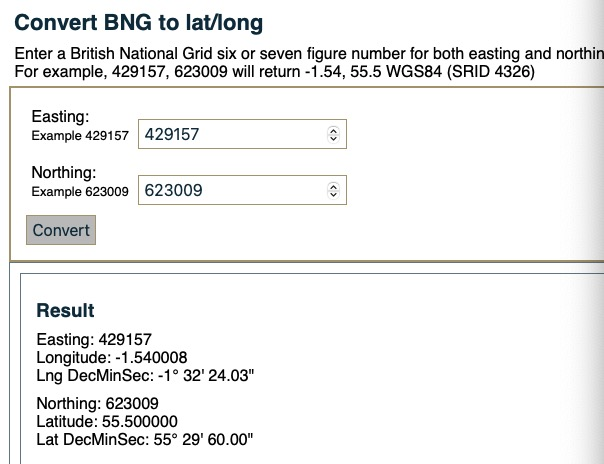

In [15]:
import numpy as np

from pytest import mark
def test_get_gps_lat_long_from_easting_northing():
    """Check """

    data1,data2 = get_gps_lat_long_from_easting_northing([429157], [623009])

    if data1 is NotImplemented:
        assert False

    assert np.isclose(data1[0], 55.5).all()
    assert np.isclose(data2[0], -1.5384).all()
    
    
if __name__ == "__main__":
    test_get_gps_lat_long_from_easting_northing()

In [17]:
import numpy as np

from pytest import mark
def test_get_gps_lat_long_from_easting_northing():
    """Check """

    data1,data2 = get_gps_lat_long_from_easting_northing([429157], [623009])

    if data1 is NotImplemented:
        assert False

    assert np.isclose(data1[0], 55.5).all()
    assert np.isclose(data2[0], -1.54).all()
    
    
if __name__ == "__main__":
    test_get_gps_lat_long_from_easting_northing()

AssertionError: 

In [9]:
class HelmertTransform(object):
    """Class to perform a Helmert Transform."""
    def __init__(self, s, rx, ry, rz, T):

        self.T = T.reshape((3, 1))

        self.M = array([[1+s, -rz, ry],
                        [rz, 1+s, -rx],
                        [-ry, rx, 1+s]])

    def __call__(self, X):
        X = X.reshape((3, -1))
        return self.T + self.M@X
    
class HelmertInverseTransform(object):
    """Class to perform the inverse of a Helmert Transform."""
    def __init__(self, s, rx, ry, rz, T):

        self.T = T.reshape((3, 1))

        self.M = inv(array([[1+s, -rz, ry],
                            [rz, 1+s, -rx],
                            [-ry, rx, 1+s]]))

    def __call__(self, X):
        X = X.reshape((3, -1))
        return self.M@(X-self.T)


OSGB36transform = HelmertTransform(20.4894e-6,
                                   -rad(0, 0, 0.1502),
                                   -rad(0, 0, 0.2470),
                                   -rad(0, 0, 0.8421),
                                   array([-446.448, 125.157, -542.060]))

WGS84transform = HelmertInverseTransform(20.4894e-6,
                                         -rad(0, 0, 0.1502),
                                         -rad(0, 0, 0.2470),
                                         -rad(0, 0, 0.8421),
                                         array([-446.448, 125.157, -542.060]))


def WGS84toOSGB36(lat, long, rads=False):
    """Convert WGS84 lat/long to OSGB36 lat/long."""
    X = OSGB36transform(lat_long_to_xyz(asarray(lat), asarray(long),
                                        rads=rads, datum=wgs84))
    return xyz_to_lat_long(*X, rads=rads, datum=osgb36)


def OSGB36toWGS84(lat, long, rads=False):
    """Convert OSGB36 lat/long to WGS84 lat/long."""
    X = WGS84transform(lat_long_to_xyz(asarray(lat), asarray(long),
                                       rads=rads, datum=osgb36))
    return xyz_to_lat_long(*X, rads=rads, datum=wgs84)
